<a href="https://colab.research.google.com/github/Zdestrion/ML_pvt_repo/blob/master/NB_randomforest_ising2D_LC2_2020_Fuiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione stato di un modello di Ising 2D con Random Forests

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Informazioni ###

scopo: imparare ad usare ensamble di modelli deboli tipo foreste random di alberi a decisione binaria 
applicazione: classificazione dello fase in cui si trovano configurazioni d i un modello di Ising 2D
ML tool: cikit-learn


### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

100k configurazioni con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis. 

Il campione è disponibile qui:

* [configurazioni](https://www.dropbox.com/s/ma1n1r2uejb9iei/ising_conf.dat?dl=0)
* [label](https://www.dropbox.com/s/dj1urxh8tsadoh5/ising_label.dat?dl=0)

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

Poiché è noto che vicino alla temepratura critica $T_c$, la lunghezza delle correlazioni ferromagnetiche diverge, rendendo difficile identificare la fase, dvideremo il campione in tre sotto-campioni:

* ordinato: $T/J<2.0$
* critico: $2.0\leq T/J\leq 2.5$
* disordinato: $T/J>2.5$

e addestreremo il modello usando solo le configurazioni ordinate e disordinate. Poi testeremo il tutto su tutte le configurazioni.

### Parte 1: load e pre-processamento del dataset ###

In [0]:
import numpy as np

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=28 # size del reticolo
J=1.0 # Ising interaction (1 ferromagnetico, -1 anti-ferromagnetico)
T_c=2.26 # Temperatura critica

In [0]:
#leggiamo le configurazioni ising dal file usando numpy (100k esempi oguno da 28x28 spin)
data = np.loadtxt('/content/drive/My Drive/Colab Notebooks/dataset/ising_conf.dat')
print(data.shape)

(2800000, 28)


NOTA: gli esempi sono scritti nel file come righe sequenziali da 28 valori l'una -> 100k x 28 = 2800000 

In [0]:
# al fine di visualizzare alcune delle configurazioni convertiamo il vettore numpy un tensore di 100K eventi ognuno 
# formato da una matrice 28x28 di spin
data = data.reshape(100000,28,28)
print(data.shape)

(100000, 28, 28)


In [0]:
#esempio
print(data[2]) #stampa 3zo evento una matrice 28x28 di valori dello spin (-1,1)

[[ 1. -1.  1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.
  -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1. -1. -1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.
   1.  1. -1.  1.  1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [-1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1.  1.
   1.  1.  1.  1.  1. -1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
 [-1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1. -1.  1.]
 [-1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [-1. -1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1

In [0]:
#leggiamo da file le label associate:
labels = np.loadtxt('/content/drive/My Drive/Colab Notebooks/dataset/ising_label.dat')
print(labels.shape)
print(labels[3]) #temperatura della configurazione del 4to evento

(100000,)
1.66324


In [0]:
# dividiamo il campione in 3 campioni sulla base dello stato (ordinato, critico, disordinato)
# T/J < 2.0 ordinato
# T/J > 2.5 disordinato
# altrimenti critico

#Crea vettori di variabili booleane
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))
    
print(cri_sele)

data_ord = data[ord_sele]
data_dis = data[dis_sele]
data_cri = data[cri_sele]

print(data_ord.shape) 
print(data_cri.shape) 
print(data_dis.shape)   

labels_ord = np.zeros(data_ord.shape[0])
labels_dis = np.ones(data_dis.shape[0])

labels_critic = labels[cri_sele]
print(labels_critic)
labels_cri = labels_critic.copy()
labels_cri[labels_critic>T_c] = 1
labels_cri[labels_critic<=T_c] = 0

print(labels_ord)
print(labels_dis)
print(labels_cri)

[False False  True ... False False False]
(40177, 28, 28)
(9808, 28, 28)
(50015, 28, 28)
[2.46347 2.18529 2.17106 ... 2.40353 2.19896 2.47125]
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
[1. 0. 0. ... 1. 0. 1.]


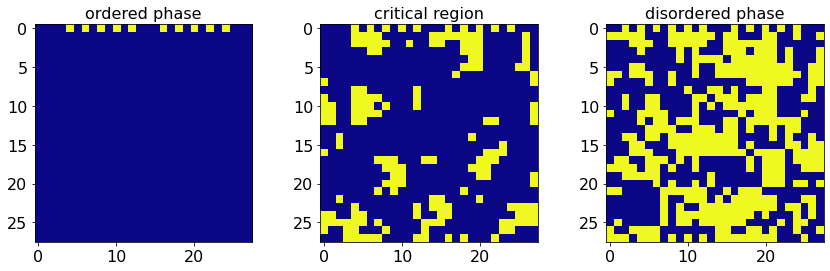

In [0]:
#una rappresentazione grafica più bella
%matplotlib inline 

#import ml_style as style
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data_ord[4],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data_cri[4],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(data_dis[4],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [0]:
##Dividiamo il campione per il training
from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

# define training and test data sets
X=np.concatenate((data_ord,data_dis))
Y=np.concatenate((labels_ord,labels_dis))

# selezioniamo random data points dai campioni ordinati e disordinati per cerare training e test
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

X_critical = data_cri
Y_critical = labels_cri

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

# riformattiamo i tensori in modo che abbiano l'input corretto atteso dagli alberi a decisione binaria 
# (vettori flat di features)   (N,28,28) -> (N, 28*28 = 784)

X_train = np.reshape(X_train, (X_train.shape[0], 28*28))
X_test = np.reshape(X_test, (X_test.shape[0], 28*28))
X_critical = np.reshape(X_critical, (X_critical.shape[0], 28*28))

X_train shape: (72153, 28, 28)
Y_train shape: (72153,)

72153 train samples
9808 critical samples
18039 test samples


### Parte 2: addestramento della Random Forests

**Iperparametri**

Usiamo l'implementazione in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) che ha due iperparamteri principali che possono modificare anche sensibimente le prestazioni del modello e il livelo di overfit/underfit: il numero di alberi nella foresta e la complessità di ciascun albero: il primo è controllato dal parametro `n_estimators`, mentre la complesiità è controllata da vari parametri `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc, in parte correlati tra loro. Nell'esempio in esame per semplicità useremo solo `min_samples_split` (governa il numero di campioni necessari per procedere ad uno split di un nodo: più alto è il numero minore sarà la segmentazione e le diramazioni dell'albero.

**NOTA: Stime OOB (Out of Bag)**

È un metodo molto utile per ottimizzare gli iperparametri quanod si usano metodi di bagging: consiste nel verificare quanto bene funziona il classificatore su qyegli eventi del trainign set che non sono stati usati nel training (perchè non campionati nella technica di boostrap). Gioca un ruolo simile alla k-fold cross-validation.

In [0]:
# Scikit-learn Random Forest
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

#Valore del numero di alberi 
min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier

n_estimator_range=np.arange(min_estimators, max_estimators, 10) #testiamo 10 valori per il primo iperparametro

leaf_size_list=[2,10000] #testiamo due valori per il seocondo iperparametro (alta segmentazione e bassa segmentazione)

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
RFC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=None, 
        min_samples_split=leaf_size, # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
    )
    for j, n_estimator in enumerate(n_estimator_range):
        
        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(X_test,Y_test)
        RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical,Y_critical)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))


n_estimators: 10, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.4626         1.0000         0.9921         0.9998         0.8019         
n_estimators: 20, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.7825         1.0000         0.9994         0.9997         0.8142         
n_estimators: 30, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.0539         1.0000         0.9996         0.9998         0.8148         
n_estimators: 40, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.3958         1.0000         0.9997         0.9998         0.8205         
n_estimators: 50, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.6626         1.0000         0.9997         0.9998         0.8193         
n_estimators: 60, leaf_size: 2
time (s)       train score    OOB estimate   test scor

**Grafico delle prestazioni:**

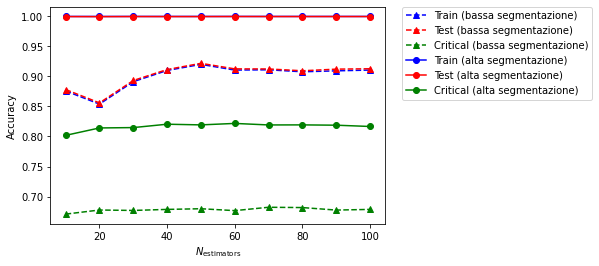

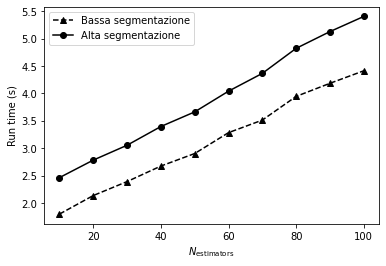

In [0]:
plt.figure()
plt.plot(n_estimator_range,RFC_train_accuracy[1],'--b^',label='Train (bassa segmentazione)')
plt.plot(n_estimator_range,RFC_test_accuracy[1],'--r^',label='Test (bassa segmentazione)')
plt.plot(n_estimator_range,RFC_critical_accuracy[1],'--g^',label='Critical (bassa segmentazione)')

plt.plot(n_estimator_range,RFC_train_accuracy[0],'o-b',label='Train (alta segmentazione)')
plt.plot(n_estimator_range,RFC_test_accuracy[0],'o-r',label='Test (alta segmentazione)')
plt.plot(n_estimator_range,RFC_critical_accuracy[0],'o-g',label='Critical (alta segmentazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Ising_RF.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(n_estimator_range, run_time[1], '--k^',label='Bassa segmentazione')
plt.plot(n_estimator_range, run_time[0], 'o-k',label='Alta segmentazione')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')


plt.legend(loc=2)
#plt.savefig("Ising_RF_Runtime.pdf")

plt.show()

### Esercizi: ###  

* provate ad implementare un classificatore basato su un semplice albero di decisione binaria in scikitlearn e confrontare le prestazioni con la foresta random

* provate ad implementare un classificatore tipo gradient boost in scikitlearn 
(*sklearn.ensemble.GradientBoostingClassifier*) ottimizzandone le prestazioni ed evitando overfitting e confrontate con la foresta random

* provate a implementare invece che una validazione OOB (gratis con le foreste random in scikit-learn) una k-fold validation (con k=5 e 10) e verificate se vi sono differenze (OOB tende a dare delle stime molto pessimistiche).
    
NOTA: per imparare ad implementare una k-fold validation in scikit-learn guardate a questo [tutorial](https://scikit-learn.org/stable/modules/cross_validation.html)

* (opzionale) provate ad addestrare un modello gradient boost in regressione (*sklearn.ensemble.GradientBoostingRegressor*)che predica le temperature associate alle configurazioni del modello di ising

#ESERCIZI:
## Albero a decisione binara
Si implementa un albero a decisione binaria utilizzando scikit learn. Si utilizza sia DecisionTreeClassifier che RandomForestClassifier con l'iperparametro n_estimators=1 per confrontare le prestazioni.

In [0]:
# Scikit-learn Decision Tree
from sklearn.tree import DecisionTreeClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

classifer = DecisionTreeClassifier

leaf_size_list=[2,100,1000,10000] #testiamo due valori per il seocondo iperparametro (alta segmentazione e bassa segmentazione)

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
RFC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Decision Tree Classifier
    print('leaf_size: %i'%(leaf_size))
    myRF_clf = classifer(
        max_depth=None, 
        min_samples_split=leaf_size, # minimum number of sample per leaf
        random_state=0,
        )

    start_time = time.time()
    myRF_clf.fit(X_train, Y_train)
    run_time[i,j] = time.time() - start_time

    # check accuracy
    RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
    RFC_test_accuracy[i,j]=myRF_clf.score(X_test,Y_test)
    RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical,Y_critical)
    if print_flag:
        result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
        print('{0:<15}{1:<15}{2:<15}{3:<15}'.format("time (s)","train score", "test score", "critical score"))
        print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}'.format(*result))


leaf_size: 2
time (s)       train score    test score     critical score 
8.2522         1.0000         0.9920         0.7119         
leaf_size: 100
time (s)       train score    test score     critical score 
8.1447         0.9880         0.9823         0.6904         
leaf_size: 1000
time (s)       train score    test score     critical score 
7.6739         0.9546         0.9512         0.6467         
leaf_size: 10000
time (s)       train score    test score     critical score 
5.8786         0.8510         0.8493         0.6036         


I risultati sembrano buoni, anche se peggiorano con l'aumentare della leafsize. Si nota però un tempo necessario alla compilazione notevole per la semplicità del compito.

In [0]:
# Scikit-learn Random Forest
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

#Valore del numero di alberi 
min_estimators = 1
max_estimators = 2
classifer = RandomForestClassifier

n_estimator_range=np.arange(min_estimators, max_estimators, 1) #testiamo 10 valori per il primo iperparametro

leaf_size_list=[2,100,1000,10000] #testiamo due valori per il seocondo iperparametro (alta segmentazione e bassa segmentazione)

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
RFC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=None, 
        min_samples_split=leaf_size, # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
    )
    for j, n_estimator in enumerate(n_estimator_range):
        
        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(X_test,Y_test)
        RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical,Y_critical)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))

n_estimators: 1, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
0.4469         0.9981         0.6479         0.9936         0.7170         
n_estimators: 1, leaf_size: 100
time (s)       train score    OOB estimate   test score     critical score 
0.4240         0.9814         0.6418         0.9790         0.7073         
n_estimators: 1, leaf_size: 1000
time (s)       train score    OOB estimate   test score     critical score 
0.4251         0.9546         0.6324         0.9496         0.6313         
n_estimators: 1, leaf_size: 10000
time (s)       train score    OOB estimate   test score     critical score 
0.3694         0.8670         0.6002         0.8662         0.6229         


Questa seconda prova, nella quale si è utilizzato RandomForestClassifier, non solo risulta migliore nei risultati, ma anche nei tempi. <br />
Specialmente quando si usa una alta segmentazione, gli score di train e test sono particolarmente alti ($\simeq 99\%$), mentre i risultati sul set critico sono bene o male in ogni caso deludenti. <br />
Viste le migliori prestazioni di questo algoritmo, per un singolo albero di decisione binaria in futuro si userà quindi RandomForest con singolo estimatore.

##Gboost

Si implementa un terzo algoritmo, il GradientBoostingClassifier, per confrontare le prestazioni. Si opera uno studio ad alta e bassa segmentazione con numero crescente di estimatori per studiarne l'andamento.

In [0]:
# Scikit-learn GBoost
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")

classifier = GradientBoostingClassifier

leaf_size_list=[2,10000]
min_estimators = 10
max_estimators = 101

n_estimator_range=np.arange(min_estimators, max_estimators, 10)

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
GBC_train_accuracy=np.zeros((n,m))
GBC_test_accuracy=np.zeros((n,m))
GBC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Gradient boost Classifier
    myGB_clf = classifier(
        loss='deviance', 
        learning_rate=0.1, 
        n_estimators=min_estimators, 
        subsample=1.0, 
        min_samples_split=leaf_size, 
        max_depth=None, 
        random_state=0, 
        warm_start=True,  
        tol=0.0001,
        ccp_alpha=0.0
    )
    for j, n_estimator in enumerate(n_estimator_range):
     
      print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))

      start_time = time.time()
      myGB_clf.set_params(n_estimators=n_estimator)
      myGB_clf.fit(X_train, Y_train)
      run_time[i,j] = time.time() - start_time   
      GBC_train_accuracy[i,j]=myGB_clf.score(X_train,Y_train)
      GBC_test_accuracy[i,j]=myGB_clf.score(X_test,Y_test)
      GBC_critical_accuracy[i,j]=myGB_clf.score(X_critical,Y_critical)
      if print_flag:
        result = (run_time[i,j], GBC_train_accuracy[i,j], GBC_test_accuracy[i,j], GBC_critical_accuracy[i,j])
        print('{0:<15}{1:<15}{2:<15}{3:<15}'.format("time (s)","train score","test score", "critical score"))
        print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}'.format(*result))      

n_estimators: 10, leaf_size: 2
time (s)       train score    test score     critical score 
82.4509        1.0000         0.9938         0.7052         
n_estimators: 20, leaf_size: 2
time (s)       train score    test score     critical score 
83.4334        1.0000         0.9937         0.7081         
n_estimators: 30, leaf_size: 2
time (s)       train score    test score     critical score 
83.3556        1.0000         0.9937         0.7084         
n_estimators: 40, leaf_size: 2
time (s)       train score    test score     critical score 
81.6224        1.0000         0.9940         0.7083         
n_estimators: 50, leaf_size: 2
time (s)       train score    test score     critical score 
81.2290        1.0000         0.9942         0.7093         
n_estimators: 60, leaf_size: 2
time (s)       train score    test score     critical score 
76.3234        1.0000         0.9948         0.7103         
n_estimators: 70, leaf_size: 2
time (s)       train score    test score     critic

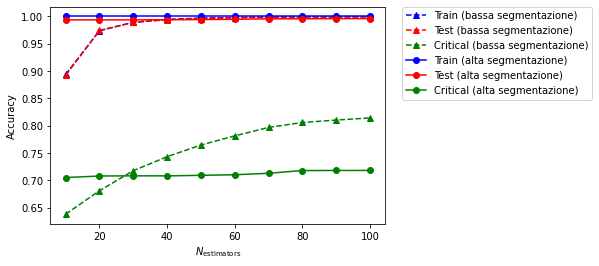

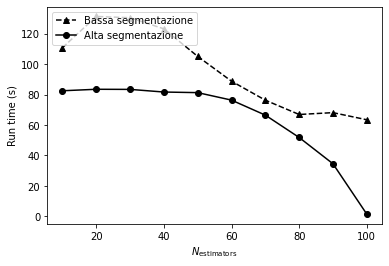

In [0]:
plt.figure()
plt.plot(n_estimator_range,GBC_train_accuracy[1],'--b^',label='Train (bassa segmentazione)')
plt.plot(n_estimator_range,GBC_test_accuracy[1],'--r^',label='Test (bassa segmentazione)')
plt.plot(n_estimator_range,GBC_critical_accuracy[1],'--g^',label='Critical (bassa segmentazione)')

plt.plot(n_estimator_range,GBC_train_accuracy[0],'o-b',label='Train (alta segmentazione)')
plt.plot(n_estimator_range,GBC_test_accuracy[0],'o-r',label='Test (alta segmentazione)')
plt.plot(n_estimator_range,GBC_critical_accuracy[0],'o-g',label='Critical (alta segmentazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Ising_RF.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(n_estimator_range, run_time[1], '--k^',label='Bassa segmentazione')
plt.plot(n_estimator_range, run_time[0], 'o-k',label='Alta segmentazione')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')


plt.legend(loc=2)
plt.savefig("Ising_GB_Runtime.pdf")

plt.show()

L'andamento riscontrato nei grafici, oltre a garantire la bontà dell'algoritmo per i valori elevati di accuracy ottenuti, conferma che è più performante una bassa segmentazione di un'alta segmentazione, a fronte di un tempo computazionale più alto. In particolare con una bassa segmentazione si ottengono valori di accuracy decisamente più alti per il set di dati critico. <br />
Nonostante i buoni risultati, si registra un run time preoccupantemente alto e dall'andamento poco prevedibile e affatto lineare rispetto al numero di estimatori. Si continuerà a preferire Random Forest, a meno di particolare potenza di calcolo.

##K-Fold Cross validation

Si implementa ora la k-fold cross validation, in modo da avere una stima più ottimistica e veritiera rispetto alla OOB già inclusa in RandomForestClassifier.


In [0]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import time
import warnings

#disabilitiamo messaggi di warning 
warnings.filterwarnings("ignore")
#Ridefinisco
X_critical = data_cri
Y_critical = labels_cri
X_critical = np.reshape(X_critical, (X_critical.shape[0], 28*28))

#Valore del numero di alberi 
min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier
pace=10

n_estimator_range=np.arange(min_estimators, max_estimators, pace) #testiamo 10 valori per il primo iperparametro

leaf_size_list=[2,10000] #testiamo due valori per il seocondo iperparametro (alta segmentazione e bassa segmentazione)

#vettori di medie di training, test e critical
mean_train = np.zeros((10,2))
mean_test =np.zeros((10,2))
crit = np.zeros((10,2))

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
RFC_critical_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

k=5
kf = KFold(n_splits=k)

for new_train_i , new_test_i in kf.split(X) :
  #print('TRAIN:', new_train_i,'TEST:',new_test_i)
  new_xtrain,new_xtest = X[new_train_i],X[new_test_i]
  new_ytrain,new_ytest = Y[new_train_i], Y[new_test_i]
  new_xtrain = np.reshape(new_xtrain, (new_xtrain.shape[0], 28*28))
  new_xtest = np.reshape(new_xtest, (new_xtest.shape[0], 28*28))

  y=0
  for i, leaf_size in enumerate(leaf_size_list):
     # Define Random Forest Classifier
      x=0
      myRF_clf = classifer(
      n_estimators=min_estimators,
      max_depth=None, 
      min_samples_split=leaf_size, # minimum number of sample per leaf
      oob_score=True,
      random_state=0,
      warm_start=True # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
      )
      for j, n_estimator in enumerate(n_estimator_range):
        
        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(new_xtrain, new_ytrain)
        run_time[i,j] = time.time() - start_time    
        

    # check accuracy

        RFC_train_accuracy[i,j]=myRF_clf.score(new_xtrain,new_ytrain)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(new_xtest,new_ytest)
        RFC_critical_accuracy[i,j]=myRF_clf.score(X_critical,Y_critical)
        mean_train[x,y] = mean_train[x,y]+RFC_train_accuracy[i,j]
        mean_test[x,y] = mean_test[x,y]+RFC_test_accuracy[i,j]
        crit[x,y] = crit[x,y]+RFC_critical_accuracy[i,j]
        x=x+1
        
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j], RFC_critical_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}{4:<15}'.format("time (s)","train score", "OOB estimate","test score", "critical score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}{4:<15.4f}'.format(*result))
      y=y+1



n_estimators: 10, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.3717         1.0000         0.9913         0.9986         0.7856         
n_estimators: 20, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.6299         1.0000         0.9997         0.9986         0.8015         
n_estimators: 30, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
2.9256         1.0000         1.0000         0.9987         0.7991         
n_estimators: 40, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.3713         1.0000         1.0000         0.9986         0.8064         
n_estimators: 50, leaf_size: 2
time (s)       train score    OOB estimate   test score     critical score 
3.6837         1.0000         1.0000         0.9983         0.8070         
n_estimators: 60, leaf_size: 2
time (s)       train score    OOB estimate   test scor

In [0]:
temp_mean_train = mean_train/k
temp_mean_test = mean_test/k
temp_crit = crit/k
pace=10
print("Crescent numbers of estimators, starting from:",min_estimators,"to",max_estimators,"with pace:",pace,"\n")
print("K-fold on the train set:\n leafsize:2  leafsize:10000\n",temp_mean_train)
print("\nK-fold on the test set:\n leafsize:2  leafsize:10000\n",temp_mean_test)
print("\nK-fold on the critical set:\n leafsize:2  leafsize:10000\n",temp_crit)

Crescent numbers of estimators, starting from: 10 to 101 with pace: 10 

K-fold on the train set:
 leafsize:2  leafsize:10000
 [[0.99998337 0.92817806]
 [0.99999446 0.9169105 ]
 [0.99999723 0.93191729]
 [1.         0.93396291]
 [1.         0.93599468]
 [1.         0.93593647]
 [1.         0.93827314]
 [1.         0.9371644 ]
 [1.         0.93654628]
 [1.         0.93669042]]

K-fold on the test set:
 leafsize:2  leafsize:10000
 [[0.99954542 0.86212054]
 [0.99968956 0.86000275]
 [0.99970065 0.86410518]
 [0.99968956 0.86485914]
 [0.99963412 0.86571289]
 [0.99970065 0.86546896]
 [0.99966739 0.86613422]
 [0.99968956 0.86577941]
 [0.99967847 0.86577941]
 [0.99970065 0.86574615]]

K-fold on the critical set:
 leafsize:2  leafsize:10000
 [[0.7968801  0.68038336]
 [0.80795269 0.68564437]
 [0.80878874 0.69267945]
 [0.81262235 0.69310767]
 [0.81227569 0.69610522]
 [0.81335644 0.69584013]
 [0.81382545 0.69708401]
 [0.81486542 0.69802202]
 [0.816823   0.69875612]
 [0.81721044 0.69900082]]


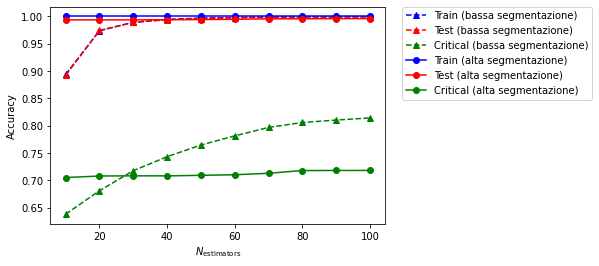

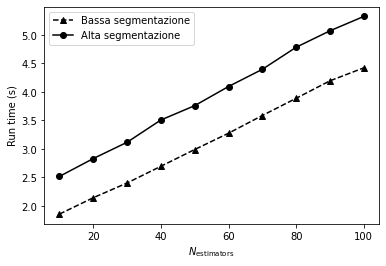

In [0]:
plt.figure()
plt.plot(n_estimator_range,GBC_train_accuracy[1],'--b^',label='Train (bassa segmentazione)')
plt.plot(n_estimator_range,GBC_test_accuracy[1],'--r^',label='Test (bassa segmentazione)')
plt.plot(n_estimator_range,GBC_critical_accuracy[1],'--g^',label='Critical (bassa segmentazione)')

plt.plot(n_estimator_range,GBC_train_accuracy[0],'o-b',label='Train (alta segmentazione)')
plt.plot(n_estimator_range,GBC_test_accuracy[0],'o-r',label='Test (alta segmentazione)')
plt.plot(n_estimator_range,GBC_critical_accuracy[0],'o-g',label='Critical (alta segmentazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Ising_RF.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

plt.plot(n_estimator_range, run_time[1], '--k^',label='Bassa segmentazione')
plt.plot(n_estimator_range, run_time[0], 'o-k',label='Alta segmentazione')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')


plt.legend(loc=2)
plt.savefig("Ising_GB_Runtime.pdf")

plt.show()

Si notano, come attese, stime più ottimistiche dell'accuracy. In particolare la bassa segmentazione inizia a produrre accuracy migliori già da 40-50 estimatori, mentre sulla segmentazione alta i risultati rimangono insoddisfacenti sul set critico. 

##GBoost regression


Si vuole infine utilizzare il Gradient Boost Regressor per predire le temperature associate alle configurazioni di spin.

In [0]:
# dividiamo il campione in 3 campioni sulla base dello stato (ordinato, critico, disordinato)
# T/J < 2.0 ordinato
# T/J > 2.5 disordinato
# altrimenti critico

ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))
lab_dis = []
lab_ord = []
lab_crit =[]
for d in labels:
  if d < 2 :
    lab_ord.append(d)
  if d > 2.5 :
    lab_dis.append(d)
  else :
    lab_crit.append(d)

In [0]:
lab_ord = np.array(lab_ord)
lab_dis = np.array(lab_dis)
lab_crit = np.array(lab_crit)

In [0]:
#si creano i campioni

from sklearn.model_selection import train_test_split
train_to_test_ratio = 0.8
X_gbr=np.concatenate((data_ord,data_dis))
Y_gbr=np.concatenate((lab_ord,lab_dis))
X_traingbr,X_testgbr,Y_traingbr,Y_testgbr=train_test_split(X_gbr,Y_gbr,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
X_critgbr = data_cri
Y_critgbr = lab_crit
X_traingbr = np.reshape(X_traingbr, (X_traingbr.shape[0], 28*28))
X_testgbr = np.reshape(X_testgbr, (X_testgbr.shape[0], 28*28))
X_critgbr = np.reshape(X_critgbr, (X_critgbr.shape[0], 28*28))

In [0]:
#training dell'algoritmo

from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

gbr = GradientBoostingRegressor(n_estimators=100)
gbr.fit(X_traingbr,Y_traingbr)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
#stampiamo una temperatura predetta e confrontiamola con quella vera

#import sys
#np.set_printoptions(threshold=sys.maxsize)
#print(X_test.shape)
print("\n")
print(gbr.predict(X_testgbr)[1])
print(Y_testgbr[1])



4.326876655307673
4.92787


Nonostante le temperature (vera e predetta) siano quantomeno definibili come simili. la differenza tra esse, messa in rapporto alla temperatura in sé non permette di accettare come successo la predizione ottenuta. Si ottiene un errore percentuale del $7.5\%$, che è ben oltre quanto si vorrebbe ottenere da un algoritmo simile. Questo perché chiaramente una percentuale d'errore così ampia non permettere di discernere tra temperatura che dà vita ad un dataset critico da uno ordinato o disordinato.

Si procede dunque al calcolo dell'accuracy in funzione di un valore di discernimento di temperatura (tolerance) $\epsilon$. E' necessario quindi avere un intervallo entro il quale csi considerano le due temperature compatibili e la relativa accuracy del modello. Da quanto osservato in precedenza ci si attende valori di accuracy accettabili solo per $\epsilon$ abbastanza grandi.

In [0]:
#Calcoliamo le accuracy

eps = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 2]

gbr_pred_train = gbr.predict(X_traingbr)
gbr_pred_test = gbr.predict(X_testgbr)
gbr_pred_crit = gbr.predict(X_critgbr)

print(gbr_pred_train.shape)
print(gbr_pred_test.shape)
print(gbr_pred_crit.shape)

(72153,)
(18039,)
(9808,)


In [0]:
gbr_acc_train = 0
gbr_acc_test = 0
gbr_acc_crit = 0

for epsilon in eps:
  for i in range(0,72153,1):
    if abs(gbr_pred_train[i]-Y_traingbr[i]) < epsilon:
      gbr_acc_train += 1

  gbr_acc_train /= 72153

  for i in range(0,18039,1):
    if abs(gbr_pred_test[i]-Y_testgbr[i]) < epsilon:
      gbr_acc_test += 1

  gbr_acc_test /= 18039

  for i in range(0,9808,1):
    if abs(gbr_pred_crit[i]-Y_critgbr[i]) < epsilon:
      gbr_acc_crit += 1

  gbr_acc_crit /= 9808

  print('Tolerance: %g'%epsilon)
  print("Accuracy on the train set: %.4f"%gbr_acc_train)
  print("Accuracy on the test set: %.4f"%gbr_acc_test)
  print("Accuracy on the critical set: %.4f"%gbr_acc_crit)
  print('\n')

Tolerance: 0.0001
Accuracy on the train set: 0.0002
Accuracy on the test set: 0.0001
Accuracy on the critical set: 0.0000


Tolerance: 0.001
Accuracy on the train set: 0.0014
Accuracy on the test set: 0.0016
Accuracy on the critical set: 0.0002


Tolerance: 0.01
Accuracy on the train set: 0.0121
Accuracy on the test set: 0.0140
Accuracy on the critical set: 0.0047


Tolerance: 0.1
Accuracy on the train set: 0.1185
Accuracy on the test set: 0.1199
Accuracy on the critical set: 0.0450


Tolerance: 0.5
Accuracy on the train set: 0.5765
Accuracy on the test set: 0.5658
Accuracy on the critical set: 0.2121


Tolerance: 1
Accuracy on the train set: 0.9109
Accuracy on the test set: 0.9053
Accuracy on the critical set: 0.4163


Tolerance: 2
Accuracy on the train set: 0.9978
Accuracy on the test set: 0.9970
Accuracy on the critical set: 0.7749




Come atteso, prima di $\epsilon = 0.5$ i valori registrati non sono neanche classificabili come accettabili. A tale valore corrisponde un'accuracy del $\simeq 57\%$ su entrambi i set (train e test). Per avere un'accuracy buona ($\simeq 90\%$ su test e train, a fronte del solo $41\%$ sul set critico) è necessario utilizzare un $\epsilon$ = 1, che è decisamente troppo alto per poter essere un valore utilizzabile. <br />
Essendo l'intervallo di temperature utilizzato [2,2.5], non ci si ritiene dunque soddisfatti di ciò che si è ottenuto e si ritiene che l'algoritmo non sia utilizzabile con efficacia.